#Entorno de ejecución

In [1]:
try:
  # %tensorflow_version only exist in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import skimage
from skimage import io

from google.colab import files

import time
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
import random

print(tf.__version__)
print(tf.keras.__version__)

2.1.0-rc1
2.2.4-tf


Using TensorFlow backend.


# Upload files

In [3]:
!wget https://challenge.kitware.com/api/v1/folder/56f42342cad3a53ead8b1b82/download \
    -O /tmp/HeartImages.zip
  
!wget https://challenge.kitware.com/api/v1/folder/56f42342cad3a53ead8b1b81/download \
    -O /tmp/HeartMasks.zip

--2020-01-20 15:25:14--  https://challenge.kitware.com/api/v1/folder/56f42342cad3a53ead8b1b82/download
Resolving challenge.kitware.com (challenge.kitware.com)... 54.208.189.152
Connecting to challenge.kitware.com (challenge.kitware.com)|54.208.189.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/HeartImages.zip’

/tmp/HeartImages.zi     [            <=>     ] 271.94M  31.9MB/s    in 9.7s    

2020-01-20 15:25:24 (28.1 MB/s) - ‘/tmp/HeartImages.zip’ saved [285149614]

--2020-01-20 15:25:26--  https://challenge.kitware.com/api/v1/folder/56f42342cad3a53ead8b1b81/download
Resolving challenge.kitware.com (challenge.kitware.com)... 54.208.189.152
Connecting to challenge.kitware.com (challenge.kitware.com)|54.208.189.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/HeartMasks.zip’

/tmp/HeartMasks.zip     [      <=>           ]   1.41M  1.18MB

In [4]:
local_zip_I = '/tmp/HeartImages.zip'
zip_ref_I = zipfile.ZipFile(local_zip_I, 'r')
zip_ref_I.extractall('/tmp') #Extract compressed volumes of images
for j in zip_ref_I.namelist(): 
  print(j) #Print volume's names
zip_ref_I.close()

local_zip_M = '/tmp/HeartMasks.zip'
zip_ref_M = zipfile.ZipFile(local_zip_M, 'r')
zip_ref_M.extractall('/tmp') #Extract compressed volumes of masks
for j in zip_ref_M.namelist():
  print(j) #Print volume's names
zip_ref_M.close()

Training dataset/training_axial_full_pat0.nii.gz
Training dataset/training_axial_full_pat1.nii.gz
Training dataset/training_axial_full_pat2.nii.gz
Training dataset/training_axial_full_pat3.nii.gz
Training dataset/training_axial_full_pat4.nii.gz
Training dataset/training_axial_full_pat5.nii.gz
Training dataset/training_axial_full_pat6.nii.gz
Training dataset/training_axial_full_pat7.nii.gz
Training dataset/training_axial_full_pat8.nii.gz
Training dataset/training_axial_full_pat9.nii.gz
Ground truth/training_axial_full_pat0-label.nii.gz
Ground truth/training_axial_full_pat1-label.nii.gz
Ground truth/training_axial_full_pat2-label.nii.gz
Ground truth/training_axial_full_pat3-label.nii.gz
Ground truth/training_axial_full_pat4-label.nii.gz
Ground truth/training_axial_full_pat5-label.nii.gz
Ground truth/training_axial_full_pat6-label.nii.gz
Ground truth/training_axial_full_pat7-label.nii.gz
Ground truth/training_axial_full_pat8-label.nii.gz
Ground truth/training_axial_full_pat9-label.nii.gz


In [0]:
def get_tensor(img_path, mask_path):
    '''
    img_path: Path to image´s volumes
    mask_path: Path to mask´s volumes
    '''
    #Extract data from path
    IMG1 = nib.load(img_path)
    D = IMG1.get_data()

    MASK1 = nib.load(mask_path)
    M = MASK1.get_data()
    #Select the region of interest on each volume
    A = D[:,D.shape[1] // 4 - 20:-D.shape[1] // 4,:]
    B = M[:,M.shape[1] // 4 - 20:-M.shape[1] // 4,:]
    #Number of slices on axial view 
    N_Img = A.shape[1]
    #Image size
    IMG_HEIGHT = 256
    IMG_WIDTH = 256

    x_data = np.zeros((N_Img, IMG_HEIGHT, IMG_WIDTH), dtype='float32') 
    y_data = np.zeros((N_Img, IMG_HEIGHT, IMG_WIDTH), dtype='uint8')

    for i in range(0,N_Img):
        
        if A.shape[0] != IMG_HEIGHT or A.shape[2] != IMG_WIDTH:
          #Re-scale image dimensions

          #Last dim is always less than 256
          pad_w = np.abs(256- A.shape[2]) 
          #Re-size the image with padding
          A_imgp = np.pad(A[:,i,:], ( (0,0) , (pad_w//2, pad_w - pad_w//2) ), mode='constant', constant_values=0)
          B_imgp = np.pad(B[:,i,:], ( (0,0) , (pad_w//2, pad_w - pad_w//2) ), mode='constant', constant_values=0)
          
          #Last dim is always more than 256
          pad_h = np.abs(A.shape[0]-256)
          if pad_h != 0:
            #Re-size the image with padding
            A_img = A_imgp[pad_h//2: -(pad_h - pad_h//2),:]
            B_img = B_imgp[pad_h//2: -(pad_h - pad_h//2),:]
          else:
            A_img = A_imgp[:,:]
            B_img = B_imgp[:,:]
            
        else:
          A_img = A[:,i,:]
          B_img = B[:,i,:]
        
        #Now every pixel value should be in the range (0,255)
        x_data[i,:,:] = ((A_img - np.min(A_img))/(np.max(A_img) - np.min(A_img))).astype('float32')*255.
        y_data[i,:,:] = B_img
          
    return x_data, y_data


In [0]:
DATA_PATH = '/tmp'
FRAME_PATH = DATA_PATH+'/Training dataset'
MASK_PATH = DATA_PATH+'/Ground truth'

#Make directories
folders = ['train_imgs', 'val_imgs']
for folder in folders:
  os.makedirs('/tmp/' + folder + '/images')
folders = ['train_masks', 'val_masks']
for folder in folders:
  os.makedirs('/tmp/' + folder + '/masks')
seed = 1
#Save data on each directory 
a = 0  
for imgs_path, msks_path in zip(zip_ref_I.namelist()[:-1], zip_ref_M.namelist()[:-1] ):
  #Data split on trainning and validation sets 
  X, Y = get_tensor('/tmp/'+ imgs_path,'/tmp/'+ msks_path)
  X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = seed)
  #Convert the mask to an image with 3 binary channels, one for each class
  y_train = to_categorical(y_train) 
  y_val = to_categorical(y_val)
  #Save each image and mask on the corresponding path
  for j in range(X_train.shape[0]):
    img = X_train[j,:,:]
    io.imsave(DATA_PATH + '/train_imgs' +  '/images' +'/image {}'.format(a) + '{}'.format(j) +'.tif', img, check_contrast = False)
    msk = y_train[j,:,:,:].astype('uint8')
    io.imsave(DATA_PATH + '/train_masks' + '/masks' +'/mask {}'.format(a) + '{}'.format(j) +'.tif', msk, check_contrast = False)
    
  for k in range(X_val.shape[0]):
    img = X_val[k,:,:]
    io.imsave(DATA_PATH + '/val_imgs' +  '/images' +'/image {}'.format(a) + '{}'.format(k) +'.tif', img, check_contrast = False)
    msk = y_val[k,:,:,:].astype('uint8')
    io.imsave(DATA_PATH + '/val_masks' + '/masks' +'/mask {}'.format(a) + '{}'.format(k) +'.tif', msk, check_contrast = False)

  a += 1

In [7]:
print("Images for training:", len(os.listdir('/tmp/train_imgs/images')))
print("Masks for training:", len(os.listdir('/tmp/train_masks/masks')))
print("Images for validation:", len(os.listdir('/tmp/val_imgs/images')))
print("Masks for validation:", len(os.listdir('/tmp/val_masks/masks')))

Images for training: 1535
Masks for training: 1535
Images for validation: 389
Masks for validation: 389


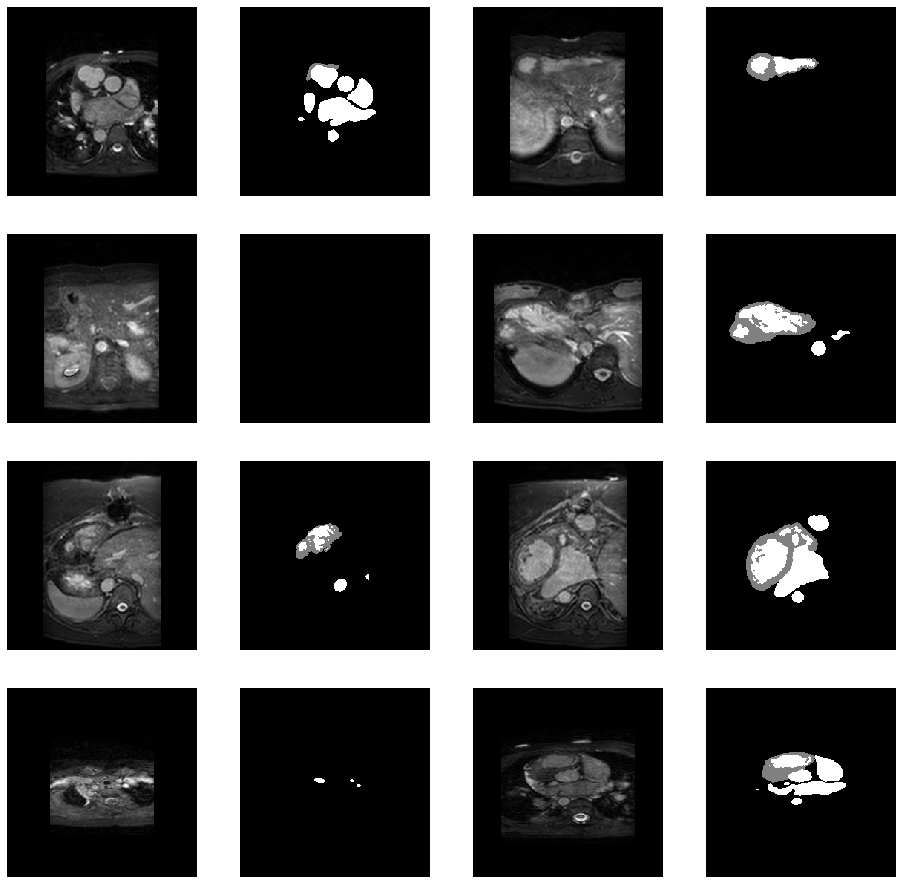

In [8]:
#Parameters for our graph; we'll output images in a 4x4 configuration 
nrows, ncols = 4, 4
N_img = nrows*2
seed = np.random.randint(low=1, high=200)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
#Path to take some of the training images 
Image_list = os.listdir('/tmp/train_imgs/images')
Mask_list = os.listdir('/tmp/train_masks/masks')
#Make sure both lists have the same order 
Image_list.sort()
Mask_list.sort()

Image = [os.path.join('/tmp/train_imgs/images', fname) 
                for fname in Image_list[seed:9*seed:seed]
               ]

Mask = [os.path.join('/tmp/train_masks/masks', fname) 
                for fname in Mask_list[seed:9*seed:seed]
               ]

for i in range(len(Image)):
  sp = plt.subplot(nrows, ncols, i*2 + 1)
  sp.axis('Off')
  img = io.imread(Image[i])
  plt.imshow(img, cmap='gray')
  
  sp = plt.subplot(nrows, ncols, i*2 + 2)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = io.imread(Mask[i])
  plt.imshow(np.argmax(img, -1), cmap='gray')

plt.show()

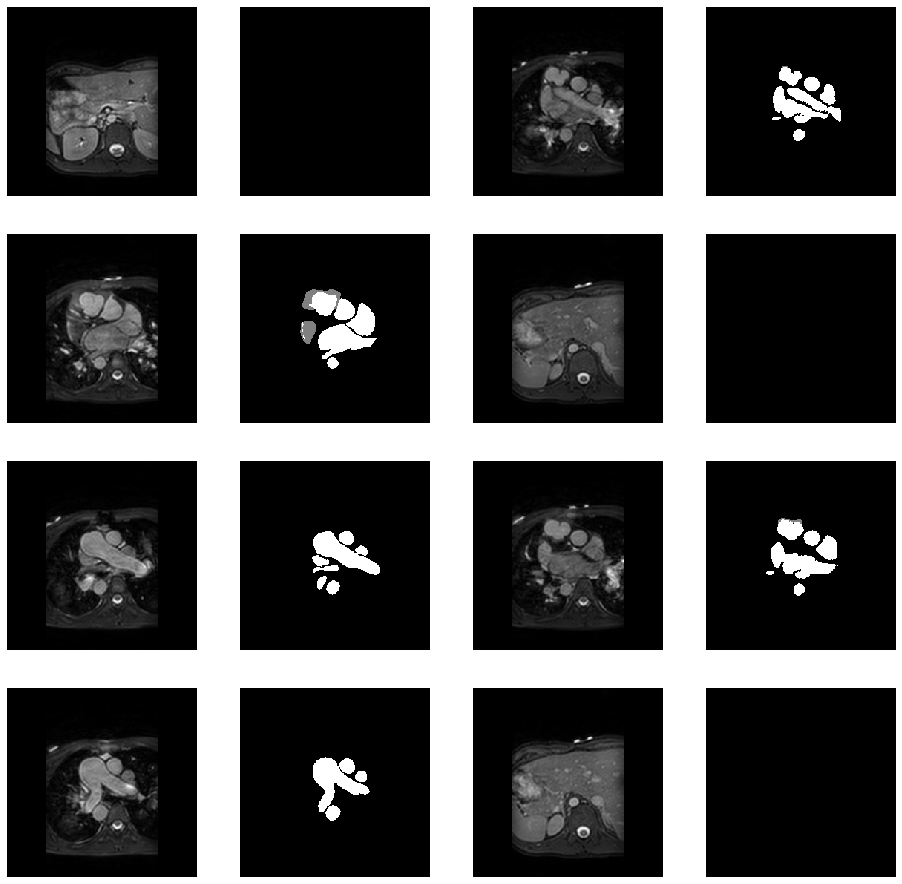

In [9]:
#Parameters for our graph; we'll output images in a 4x4 configuration 
nrows, ncols = 4, 4
N_img = nrows*2
seed = np.random.randint(low=1, high=20)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
#Path to take some of the training images 
Image_list = os.listdir('/tmp/val_imgs/images')
Mask_list = os.listdir('/tmp/val_masks/masks')
#Make sure both lists have the same order 
Image_list.sort()
Mask_list.sort()

Image = [os.path.join('/tmp/val_imgs/images', fname) 
                for fname in Image_list[seed:9*seed:seed]
               ]

Mask = [os.path.join('/tmp/val_masks/masks', fname) 
                for fname in Mask_list[seed:9*seed:seed]
               ]

for i in range(len(Image)):
  sp = plt.subplot(nrows, ncols, i*2 + 1)
  sp.axis('Off')
  img = io.imread(Image[i])
  plt.imshow(img, cmap='gray')
  
  sp = plt.subplot(nrows, ncols, i*2 + 2)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = io.imread(Mask[i])
  plt.imshow(np.argmax(img, -1), cmap='gray')

plt.show()

#Data Pipeline and augmentation

In [0]:
def my_traingenerator(SEED = None):
  
    if SEED == None:
      SEED = 3 
    #Transformations for the images on the training set
    data_gen_args1 = dict(samplewise_center= True, #Mean = 0
                     samplewise_std_normalization = True, #Std = 1
                     rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.15,
                     horizontal_flip=True)
    #Transformations for the masks on the training set                    
    data_gen_args2 = dict(rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.15,
                     horizontal_flip=True)                      

    image_datagen = ImageDataGenerator(**data_gen_args1)
    mask_datagen = ImageDataGenerator(**data_gen_args2)

    image_generator = image_datagen.flow_from_directory('/tmp/train_imgs',
                                                        batch_size=4,
                                                        class_mode=None,
                                                        target_size=(256, 256),
                                                        color_mode = 'grayscale',
                                                        seed = SEED)                                                    

    mask_generator = mask_datagen.flow_from_directory('/tmp/train_masks',
                                                        batch_size=4,
                                                        class_mode=None,
                                                        target_size=(256, 256),
                                                        color_mode = 'rgb',
                                                        seed = SEED)  
  
    while True:
        yield image_generator.next(), mask_generator.next()


In [0]:
def my_valgenerator(SEED = None):
  
    if SEED == None:
      SEED = 1 
    #Transformations for the images on the validation set
    data_gen_args1 = dict(samplewise_center= True, #Mean=0
                     samplewise_std_normalization = True, #Std=1
                     rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.15,
                     horizontal_flip=True)
    #Transformations for the masks on the validation set                    
    data_gen_args2 = dict(rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.15,
                     horizontal_flip=True)                       

    image_datagen = ImageDataGenerator(**data_gen_args1)
    mask_datagen = ImageDataGenerator(**data_gen_args2)

    image_generator = image_datagen.flow_from_directory('/tmp/val_imgs',
                                                        batch_size=4,
                                                        class_mode=None,
                                                        target_size=(256, 256),
                                                        color_mode = 'grayscale',
                                                        seed = SEED)                                                    

    mask_generator = mask_datagen.flow_from_directory('/tmp/val_masks',
                                                        batch_size=4,
                                                        class_mode=None,
                                                        target_size=(256, 256),
                                                        color_mode = 'rgb',
                                                        seed = SEED)  
  
    while True:
        yield image_generator.next(), mask_generator.next()


Found 1535 images belonging to 1 classes.
Found 1535 images belonging to 1 classes.


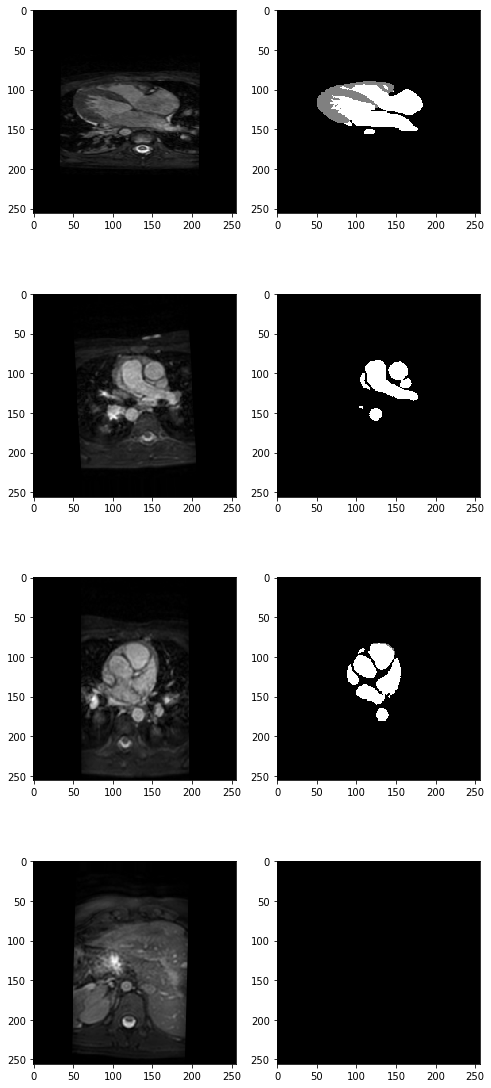

(4, 256, 256, 3) float32 0.0 1.0
(4, 256, 256, 1) float32 -0.7275733 8.335141


In [12]:
#Sample of training transformations
image_batch, mask_batch = next(my_traingenerator())
fix, ax = plt.subplots(4,2, figsize=(8,20))
for i in range(4):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(np.argmax(mask_batch[i], -1) ,cmap='gray')
plt.show()

print(mask_batch.shape, mask_batch.dtype, mask_batch.min(), mask_batch.max())
print(image_batch.shape, image_batch.dtype, image_batch.min(), image_batch.max())

Found 389 images belonging to 1 classes.
Found 389 images belonging to 1 classes.


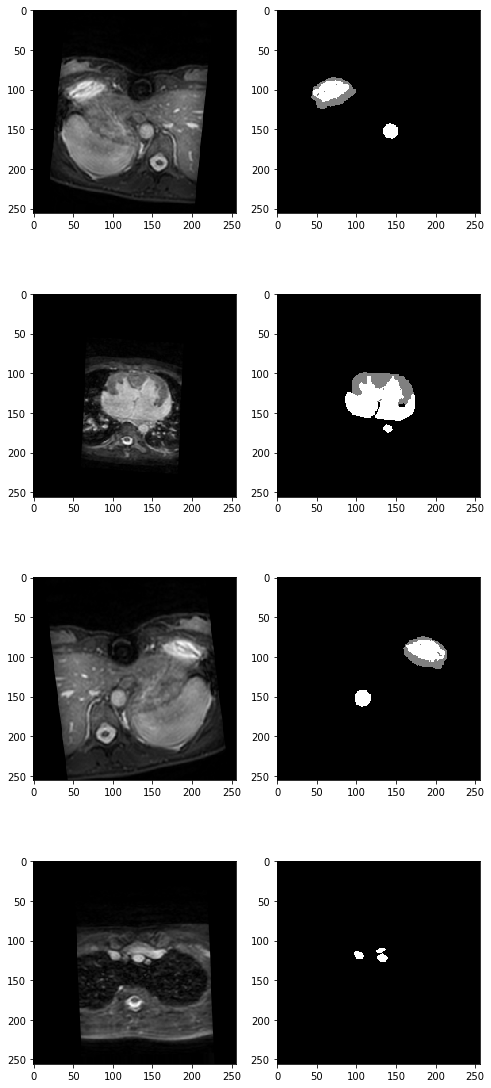

(4, 256, 256, 3) float32 0.0 1.0
(4, 256, 256, 1) float32 -0.89920413 7.073554


In [13]:
#Sample of validation transformations
image_batch, mask_batch = next(my_valgenerator()) 
fix, ax = plt.subplots(4,2, figsize=(8,20))
for i in range(4):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(np.argmax(mask_batch[i], -1),cmap='gray')
plt.show()

print(mask_batch.shape, mask_batch.dtype, mask_batch.min(), mask_batch.max())
print(image_batch.shape, image_batch.dtype, image_batch.min(), image_batch.max())

# Definir el modelo 

In [15]:
files.upload()

Saving load_model.py to load_model.py


{'load_model.py': b'# -*- coding: utf-8 -*-\r\n"""\r\nCreated on Sun Dec  8 22:22:11 2019\r\n@author: Steve Alejandro Avenda\xc3\xb1o Garc\xc3\xada\r\n"""\r\nimport tensorflow as tf\r\nfrom tensorflow import keras\r\n\r\nfrom tensorflow.python.keras import layers\r\nfrom tensorflow.python.keras import losses\r\nfrom tensorflow.python.keras import models\r\nimport numpy as np\r\n\r\nclass model:\r\n            \r\n    def conv_block(self, input_tensor, num_filters):\r\n        encoder = self.Convolution(num_filters = num_filters, IN = input_tensor)\r\n        encoder = layers.BatchNormalization(axis=-1)(encoder)\r\n        encoder = layers.Activation(\'relu\')(encoder)\r\n        encoder = layers.SpatialDropout2D(0.2)(encoder)\r\n        encoder = self.Convolution(num_filters = num_filters, IN = encoder)\r\n        encoder = layers.BatchNormalization(axis=-1)(encoder)\r\n        encoder = layers.Activation(\'relu\')(encoder)\r\n        encoder = layers.SpatialDropout2D(0.2)(encoder)\r\n

In [0]:
import load_model

In [0]:
#model = load_model.model('Dense').Unet()
model = load_model.model('Separable').Unet()
#model.summary()

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 256, 256, 64) 137         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Salvar y aplicar el modelo

In [19]:
batch_size = 4
epochs = 50
save_model_path = 'Corazon.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_generalised_dice_loss', save_best_only=True, verbose=1)

start = time.time()
historial = model.fit_generator(my_traingenerator(), 
                      epochs=epochs,
                      steps_per_epoch = int(np.ceil(len(os.listdir('/tmp/train_imgs/images'))) / float(batch_size)),
                      validation_data=my_valgenerator(), 
                      validation_steps = int(np.ceil(len(os.listdir('/tmp/val_imgs/images'))) / float(batch_size)),
                      callbacks=[cp])

end = time.time()
tiempo = end - start

Instructions for updating:
Please use Model.fit, which supports generators.
Found 1535 images belonging to 1 classes.
Found 1535 images belonging to 1 classes.
  ...
    to  
  ['...']
Found 389 images belonging to 1 classes.
Found 389 images belonging to 1 classes.
  ...
    to  
  ['...']
Train for 383 steps, validate for 97 steps
Epoch 1/50
382/383 [============================>.] - ETA: 0s - loss: 0.8702 - generalised_dice_loss: 0.5496
Epoch 00001: val_generalised_dice_loss improved from inf to 0.56600, saving model to Corazon.hdf5
383/383 [==============================] - 160s 417ms/step - loss: 0.8696 - generalised_dice_loss: 0.5496 - val_loss: 0.7149 - val_generalised_dice_loss: 0.5660
Epoch 2/50
382/383 [============================>.] - ETA: 0s - loss: 0.6006 - generalised_dice_loss: 0.4556
Epoch 00002: val_generalised_dice_loss improved from 0.56600 to 0.43443, saving model to Corazon.hdf5
383/383 [==============================] - 151s 394ms/step - loss: 0.6004 - generalise

In [20]:
print('total time = ', tiempo/60, ' min')

total time =  123.28765162229539  min


#Visualizar Entrenamiento

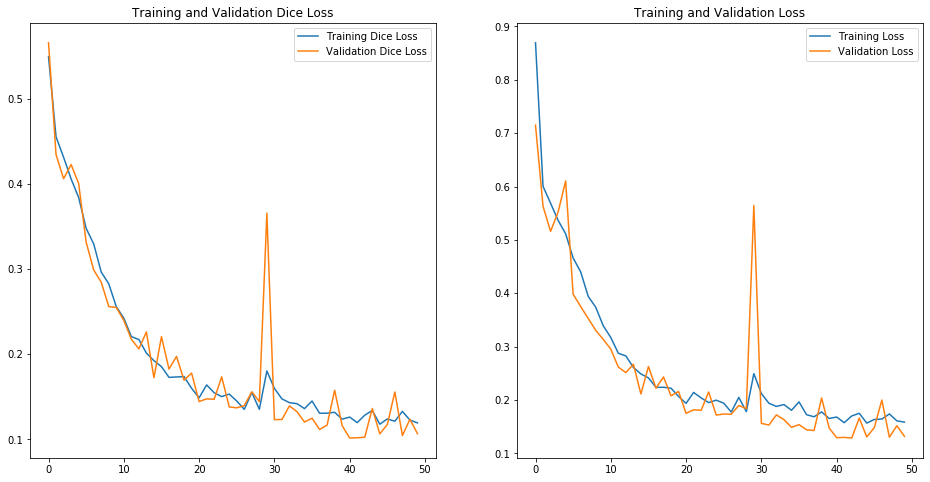

In [21]:
dice = historial.history['generalised_dice_loss']
val_dice = historial.history['val_generalised_dice_loss']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#Visualizar desempeño

##Set de evaluación

In [22]:
#Select the data from the testing set
x_test, y_test = get_tensor('/tmp/'+ zip_ref_I.namelist()[-1],'/tmp/'+ zip_ref_M.namelist()[-1])

for i in range(x_test.shape[0]):
  new_x = (x_test[i,:,:] - np.mean(x_test[i,:,:]))/(np.std(x_test[i,:,:]))
  x_test[i,:,:] = new_x 

x_test = x_test[:,:,:,np.newaxis]
y_test = to_categorical(y_test)
print(x_test.shape, x_test.dtype, x_test.min(), x_test.max(), np.mean(x_test))
print(y_test.shape, y_test.dtype, y_test.min(), y_test.max())

(212, 256, 256, 1) float32 -1.0535274 7.687883 2.1437991e-09
(212, 256, 256, 3) float32 0.0 1.0


##Evaluar

In [27]:
#Evaluate the model on the testing set
scores = model.evaluate(x = x_test, y = y_test, batch_size = 2)
print(scores)
print(model.metrics_names)

212/212 [==============================] - 3s 13ms/sample - loss: 0.3012 - generalised_dice_loss: 0.1925
[0.3012472804424898, 0.19245036]
['loss', 'generalised_dice_loss']


#Usar el modelo para predecir 

In [0]:
model.load_weights('Corazon.hdf5')

In [28]:
#Predict the masks of the testing set
predicted_label = model.predict(x_test)
print(predicted_label.shape, predicted_label.dtype, predicted_label.min(), predicted_label.max())

(212, 256, 256, 3) float32 4.2169253e-22 1.0


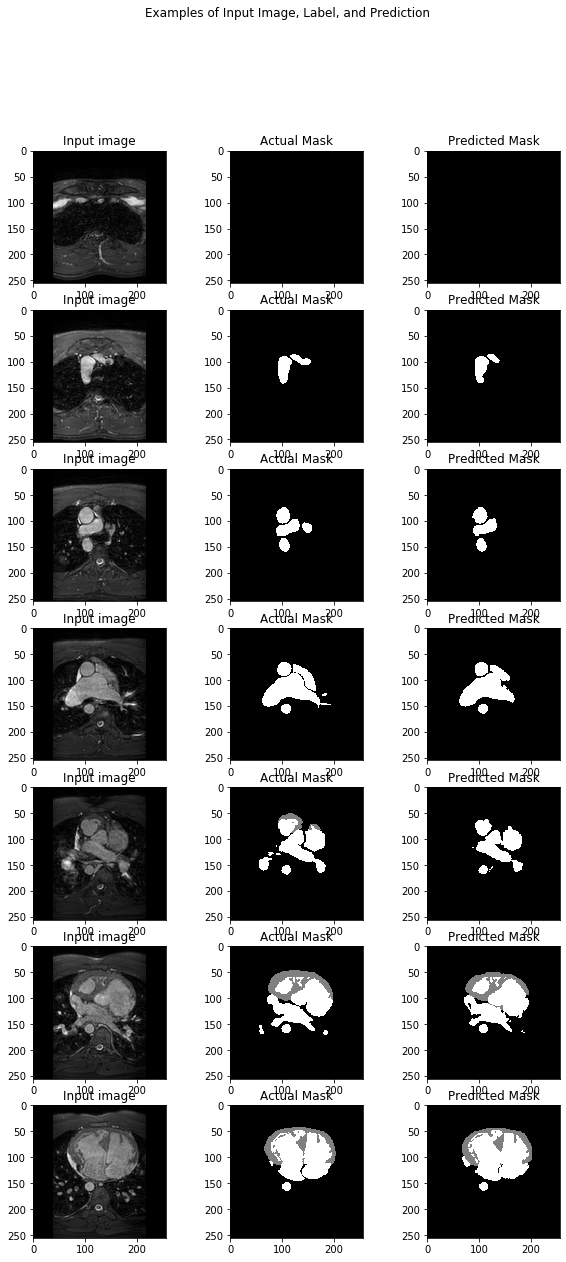

In [29]:
#Show gt masks and predicted masks
plt.figure(figsize=(10, 20))
for i in range(7):

    plt.subplot(7, 3, 3 * i + 1)
    plt.imshow(x_test[20*i,:,:,0], cmap='gray')
    plt.axis('Off')
    plt.title("Input image")

    plt.subplot(7, 3, 3 * i + 2)
    plt.imshow(np.argmax(y_test[20*i,:,:,:], -1), cmap='gray')
    plt.axis('Off')
    plt.title("Actual Mask")

    plt.subplot(7, 3, 3 * i + 3)
    plt.imshow(np.argmax(predicted_label[20*i,:,:,:], -1), cmap='gray')
    plt.axis('Off')
    plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

In [0]:
#Use argmax to assign each pixel to an specific class according to... 
#... the probability value
predicted_label_int = np.argmax(predicted_label,-1) 

In [0]:
def eval_dice_loss(y_pred, y_true):
  coefs = np.zeros(( y_pred.shape[-1], y_pred.shape[0] ))
  for i in range(0, y_pred.shape[-1]):
    for j in range(0, y_pred.shape[0]):
      intersection = 2 * np.sum(np.multiply(y_pred[j,:,:,i], y_true[j,:,:,i]))
      union = np.sum(y_pred[j,:,:,i] + y_true[j,:,:,i]) 
      coefs[i,j] = (intersection + .1)/(union + .1)

  return coefs

In [37]:
#Evaluate Dice coefficients on each channel
A = eval_dice_loss(to_categorical(predicted_label_int), y_test)
print('Dice Coef Background = ',np.mean(A[0,:]).round(2))
print('Dice Coef Myocardium = ',np.mean(A[1,:]).round(2))
print('Dice Coef Blood Pool = ',np.mean(A[2,:]).round(2))
print('Mean Dice Coef = ',np.mean(A).round(2))

Dice Coef Background =  0.99
Dice Coef Myocardium =  0.75
Dice Coef Blood Pool =  0.72
Mean Dice Coef =  0.82


In [0]:
#Evaluate CCE on each channel
def eval_cce_loss(y_pred, y_true):
  coefs = np.zeros(( y_pred.shape[-1], y_pred.shape[0] ))
  for i in range(0, y_pred.shape[-1]):
    for j in range(0, y_pred.shape[0]):
      cce = np.sum(np.multiply(y_true[j,:,:,i], np.log(y_pred[j,:,:,i]+0.001)))/(256*256)
      coefs[i,j] = cce

  return -coefs

In [41]:
B = eval_cce_loss(to_categorical(predicted_label_int), y_test)
print('CCE Background = ',np.mean(B[0,:]).round(2))
print('CCE Myocardium = ',np.mean(B[1,:]).round(2))
print('CCE Blood Pool = ',np.mean(B[2,:]).round(2))
print('CCE Coef = ',np.mean(B).round(2))

CCE Background =  0.01
CCE Myocardium =  0.05
CCE Blood Pool =  0.06
CCE Coef =  0.04


In [0]:
#Functions used to show the contours of each class...
#... over the corresponding image
import cv2 as cv
def mask_to_contours(image, mask_layer,color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """
    contours, hierarchy = cv.findContours(np.array(mask_layer), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    img = cv.drawContours(image, contours, -1, color,thickness=1)
    return img

def visualise_mask(image, mask):
  colores = [(0,0,0),(255,0,0),(255,255,0),(0,255,0),(200,79,45)]
  for index in range(mask.shape[-1]):
      # add the contours, layer per layer 
      image = mask_to_contours(image, mask[:,:,index], color=colores[index])   
  return image

def plot_masks(img,mask):
  image = np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
  for j in range(3):
    image[:,:,j] = img
  I = visualise_mask(image, mask)
  plt.imshow(I)


In [0]:
predicted_mask = to_categorical(predicted_label_int).astype('uint8')

In [0]:
img_bc, msk_bc = get_tensor('/tmp/'+ zip_ref_I.namelist()[-1],'/tmp/'+ zip_ref_M.namelist()[-1])

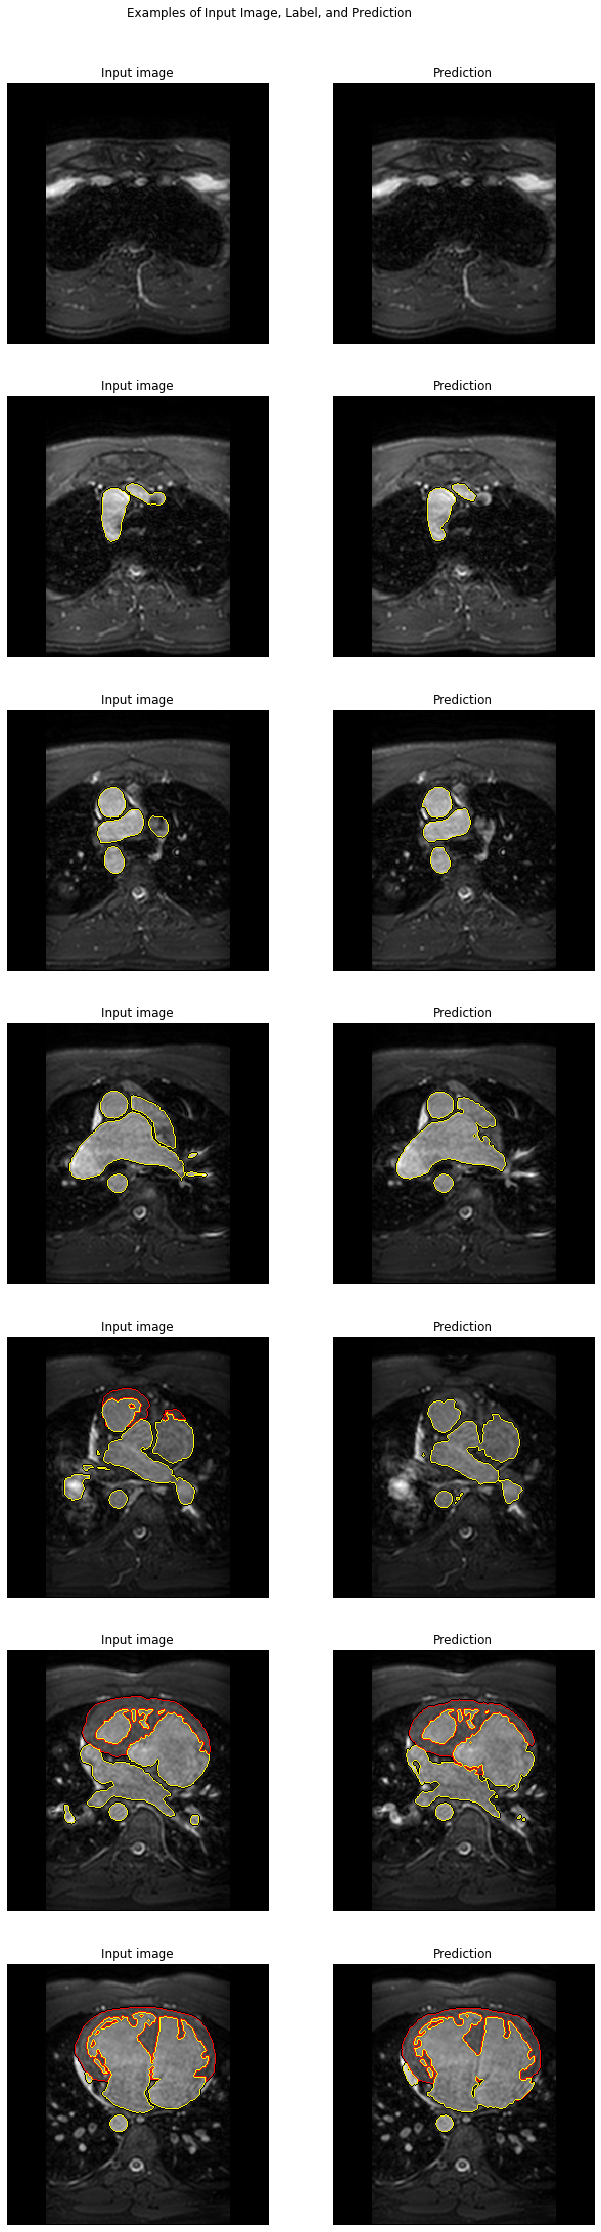

In [53]:
fig = plt.gcf()
fig.set_size_inches(35, 35)
for i in range(7):

    plt.subplot(7, 2, 2 * i + 1)
    plot_masks(img_bc[20*i,:,:].astype('uint8'), to_categorical(msk_bc[20*i], dtype='uint8'))
    plt.axis('Off')
    plt.title("Input image")

    plt.subplot(7, 2, 2 * i + 2)
    plot_masks(img_bc[20*i,:,:].astype('uint8'), predicted_mask[20*i].astype('uint8'))
    plt.axis('Off')
    plt.title("Prediction")
    
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.95, wspace=-0.8, hspace=0.2)
plt.show()